In [1]:
import scanpy as sc
import scrublet as scr
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import gseapy as gp
from scipy.sparse import csc_matrix
import anndata

In [3]:
adata = sc.read_h5ad('../assets/BRCA_GSE161529_expression_doublets.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 332168 × 27188
    obs: 'doublet_score'
    var: 'gene_ids', 'gene_symbols', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'

In [8]:
adata.obs['doublet_score'].describe()

count    332168.000000
mean          0.026695
std           0.054546
min           0.000335
25%           0.005757
50%           0.011679
75%           0.024458
max           0.965043
Name: doublet_score, dtype: float64

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

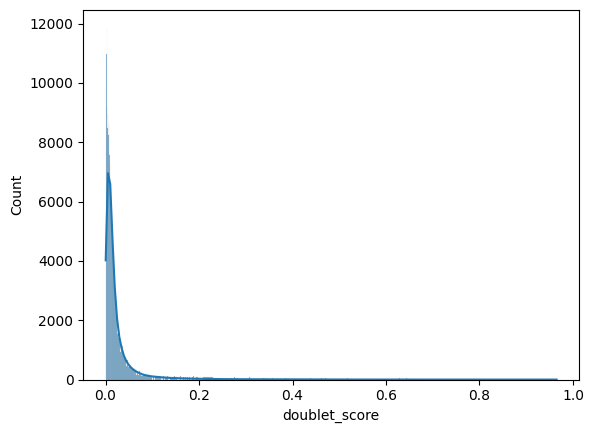

In [12]:
sns.histplot(data=adata.obs, x='doublet_score', kde=True)
plt.show()

In [27]:
adata.obs['doublet_score_group'] = pd.qcut(
    adata.obs['doublet_score'],
    q=5,
    labels=['low', 'mid-low', 'mid', 'mid-high', 'high'],
)

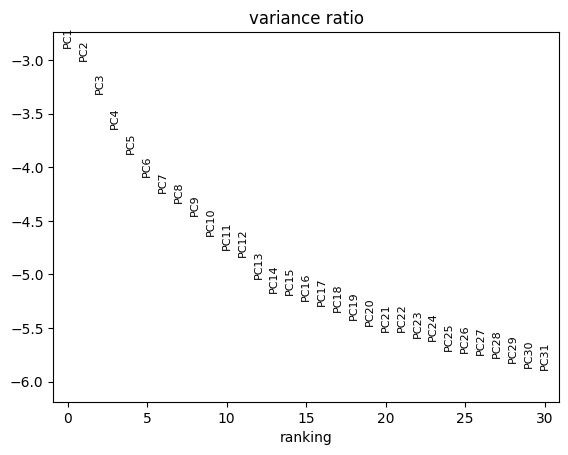

In [19]:
# 1. Compute PCA if not already done
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [20]:
# 2. Compute the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=12)

# 3. Run UMAP
sc.tl.umap(adata)

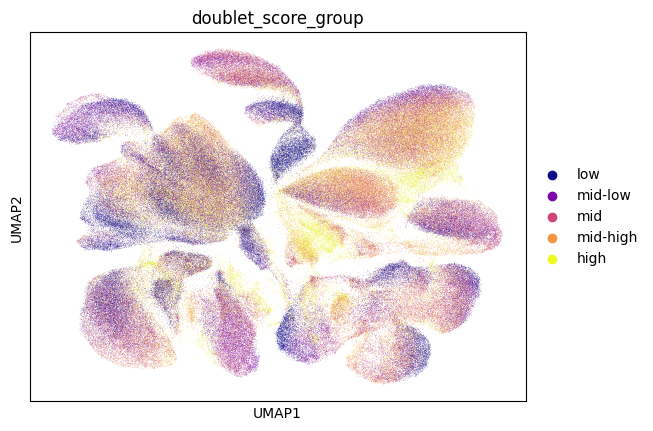

In [29]:
sc.pl.umap(adata, color='doublet_score_group', palette='plasma')

In [35]:
adata.obs['doublet_filtered'] = 'keep'
adata.obs.loc[adata.obs['doublet_score'] > 0.25, 'doublet_filtered'] = 'drop'

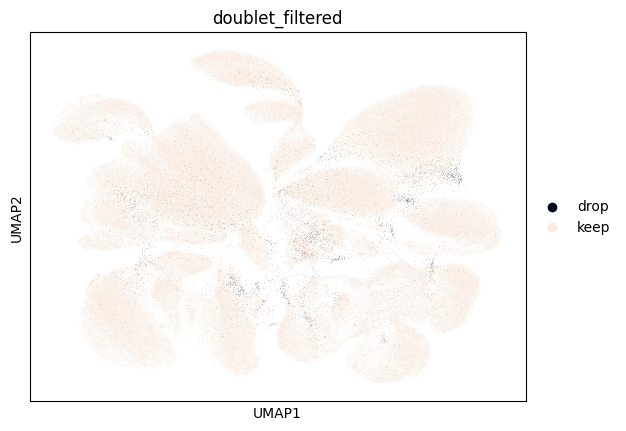

In [44]:
sc.pl.umap(adata, color='doublet_filtered', palette='rocket')

In [76]:
adata_drop = adata[adata.obs['doublet_filtered'] == 'drop'].copy()

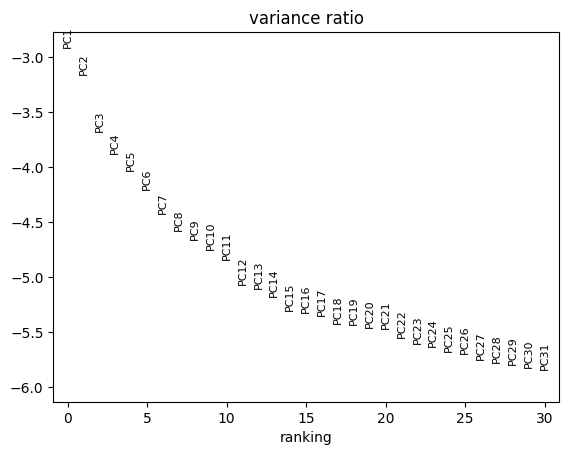

In [47]:
# 1. Compute PCA if not already done
sc.tl.pca(adata_drop, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_drop, log=True)

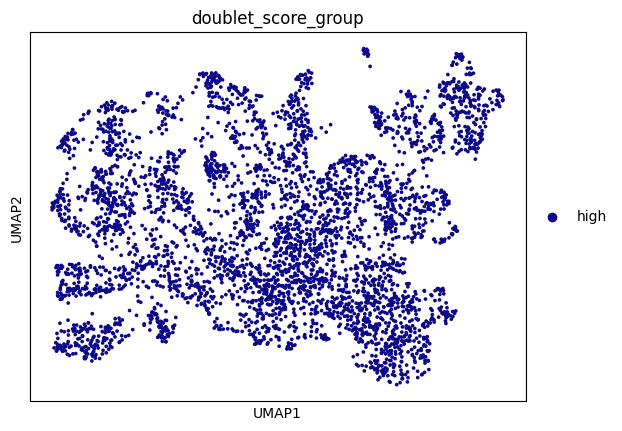

In [48]:
# 2. Compute the neighborhood graph
sc.pp.neighbors(adata_drop, n_neighbors=10, n_pcs=10)

# 3. Run UMAP
sc.tl.umap(adata_drop)
sc.pl.umap(adata_drop, color='doublet_score_group', palette='plasma')

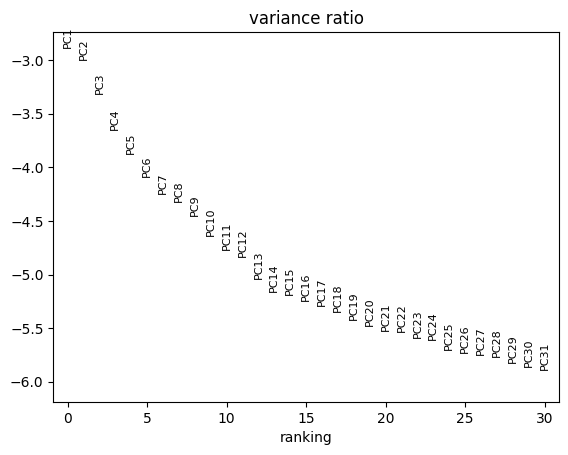

In [49]:
adata_keep = adata[adata.obs['doublet_filtered'] == 'keep'].copy()
# 1. Compute PCA if not already done
sc.tl.pca(adata_keep, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_keep, log=True)

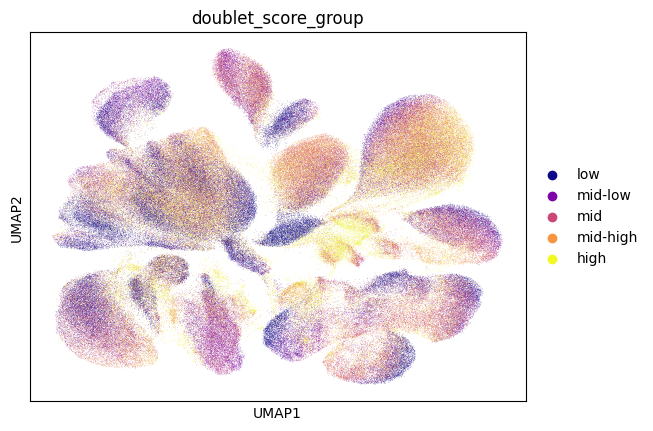

In [50]:
# 2. Compute the neighborhood graph
sc.pp.neighbors(adata_keep, n_neighbors=10, n_pcs=12)

# 3. Run UMAP
sc.tl.umap(adata_keep)
sc.pl.umap(adata_keep, color='doublet_score_group', palette='plasma')

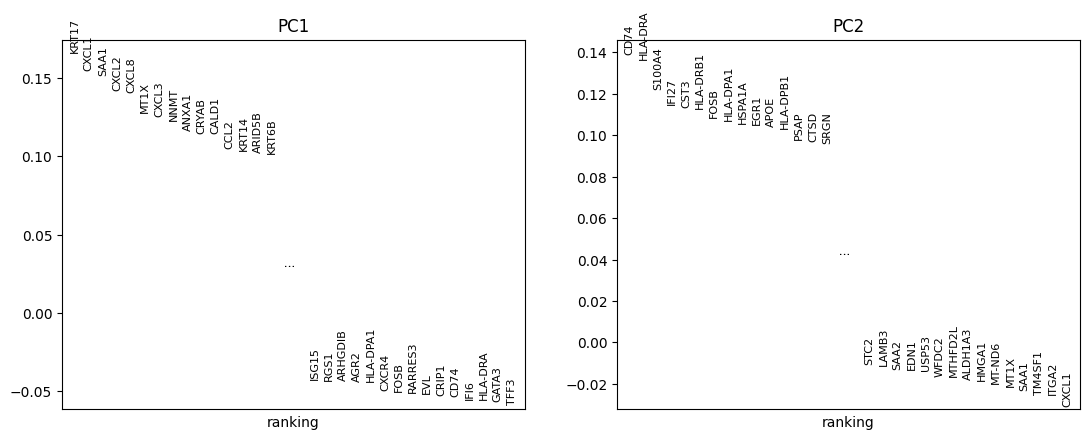

In [53]:
sc.pl.pca_loadings(adata_drop, components=[1,2])

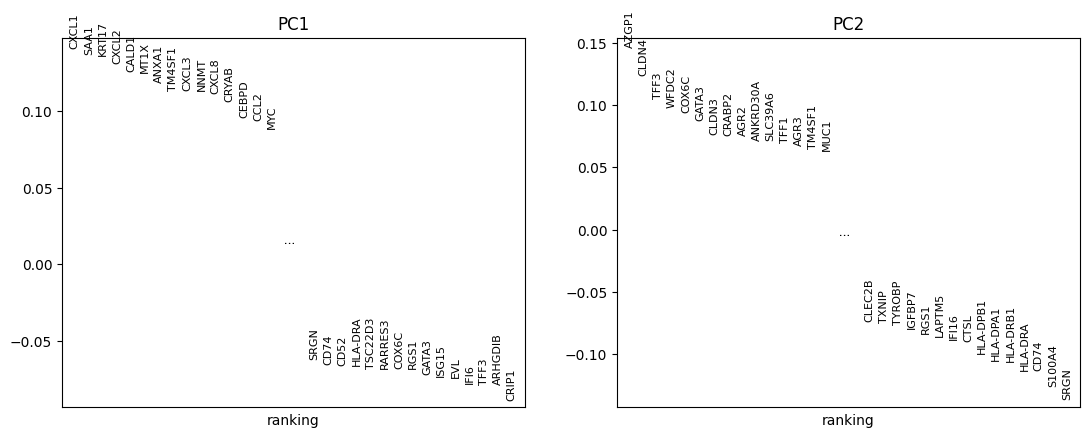

In [54]:
sc.pl.pca_loadings(adata_keep, components=[1,2])

In [66]:
temp = sc.read_h5ad('../assets/BRCA_GSE161529_expression_skc_doublet_onehotencoded.h5ad')

In [70]:
onehot_cols = [col for col in temp.obs.columns if col.startswith('TS_')]

In [74]:
onehot_df = temp.obs[onehot_cols]
decoded_labels = onehot_df.idxmax(axis=1)
decoded_labels = decoded_labels.str.replace('TS_', '')

In [75]:
adata.obs['tumor_subtype'] = decoded_labels.astype('category')

In [83]:
adata.obs['tumor_subtype'].unique()

['Normal', 'BRCA1 pre-neoplastic', 'Triple negative tumour', 'Triple negative BRCA1 tumour', 'HER2+ tumour', 'PR+ tumour', 'ER+ tumour']
Categories (7, object): ['BRCA1 pre-neoplastic', 'ER+ tumour', 'HER2+ tumour', 'Normal', 'PR+ tumour', 'Triple negative BRCA1 tumour', 'Triple negative tumour']

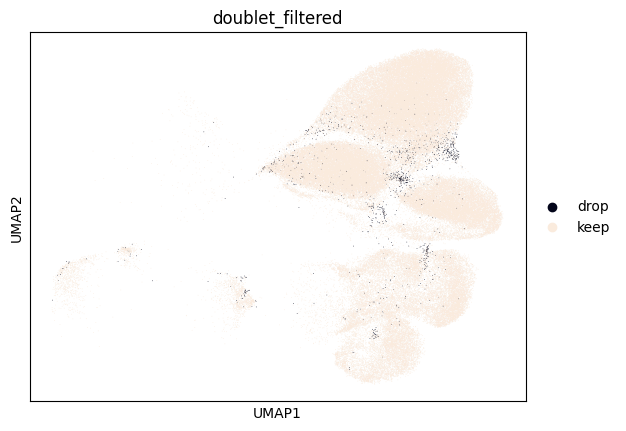

In [84]:
sc.pl.umap(adata[adata.obs['tumor_subtype'] == 'Normal'], color=['doublet_filtered'])

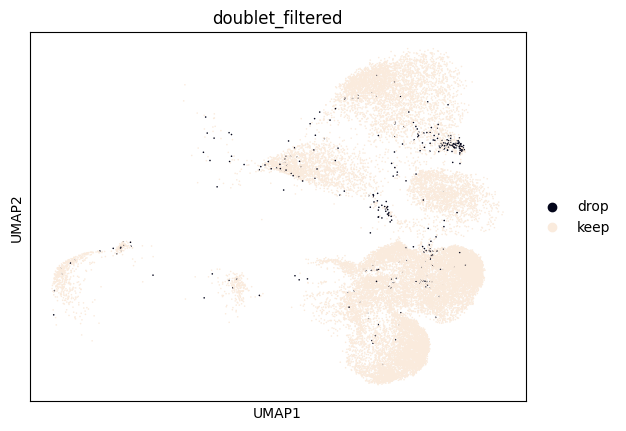

In [86]:
sc.pl.umap(adata[adata.obs['tumor_subtype'] == 'BRCA1 pre-neoplastic'], color=['doublet_filtered'])

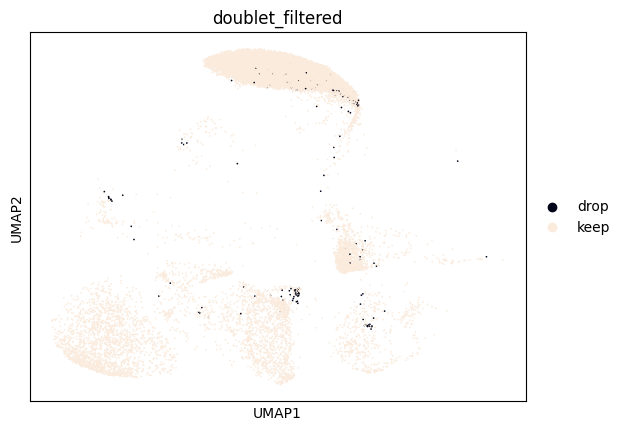

In [87]:
sc.pl.umap(adata[adata.obs['tumor_subtype'] == 'Triple negative tumour'], color=['doublet_filtered'])

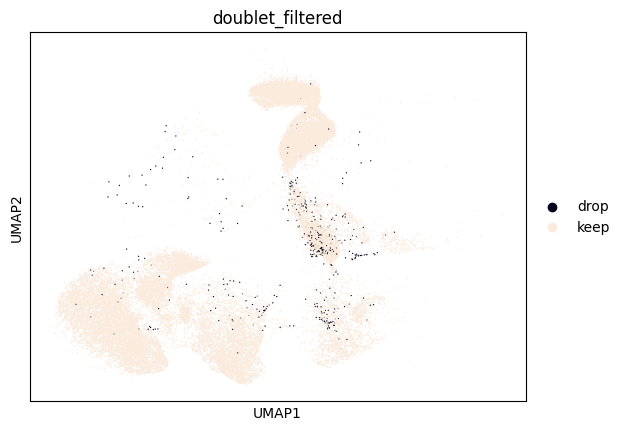

In [88]:
sc.pl.umap(adata[adata.obs['tumor_subtype'] == 'Triple negative BRCA1 tumour'], color=['doublet_filtered'])

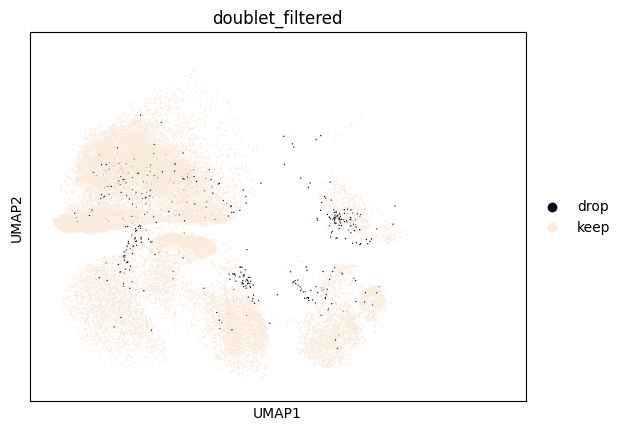

In [89]:
sc.pl.umap(adata[adata.obs['tumor_subtype'] == 'HER2+ tumour'], color=['doublet_filtered'])

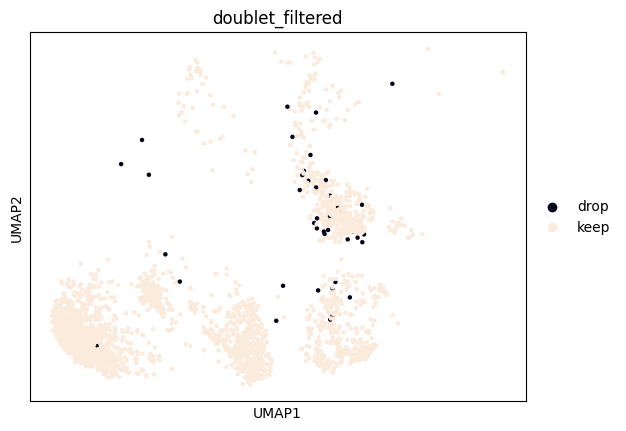

In [90]:
sc.pl.umap(adata[adata.obs['tumor_subtype'] == 'PR+ tumour'], color=['doublet_filtered'])

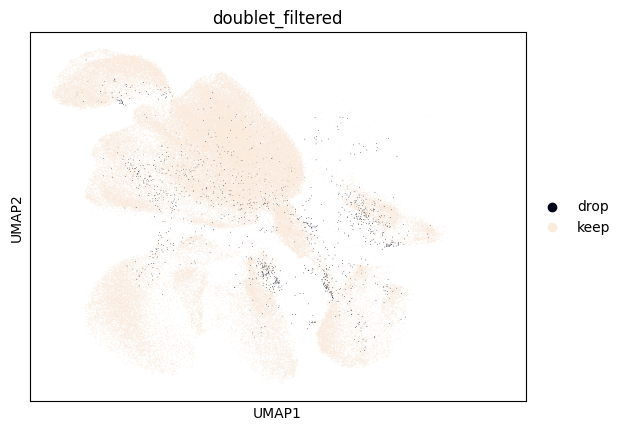

In [91]:
sc.pl.umap(adata[adata.obs['tumor_subtype'] == 'ER+ tumour'], color=['doublet_filtered'])

In [98]:
normal_dropped = adata[(adata.obs['tumor_subtype'] == 'Normal') & (adata.obs['doublet_filtered']=='drop')]
normal_kept = adata[(adata.obs['tumor_subtype'] == 'Normal') & (adata.obs['doublet_filtered']!='drop')]

abnormal_dropped = adata[(adata.obs['tumor_subtype'] != 'Normal') & (adata.obs['doublet_filtered']=='drop')]
abnormal_kept = adata[(adata.obs['tumor_subtype'] != 'Normal') & (adata.obs['doublet_filtered']!='drop')]

In [101]:
len(normal_dropped)/len(normal_kept), len(abnormal_dropped)/len(abnormal_kept)

(0.01085016048617599, 0.013684923843785389)

In [102]:
tumor_subtypes = list(adata.obs['tumor_subtype'].unique())

In [106]:
for ts in tumor_subtypes:
    dropped = adata[(adata.obs['tumor_subtype'] == ts) & (adata.obs['doublet_filtered']=='drop')]
    kept = adata[(adata.obs['tumor_subtype'] == ts) & (adata.obs['doublet_filtered']!='drop')]
    total = len(dropped)+len(kept)
    print(f"{ts} ({total}): {len(dropped)/total} - {len(kept)/total}")

Normal (109282): 0.010733698138760272 - 0.9892663018612398
BRCA1 pre-neoplastic (23212): 0.014216784421850768 - 0.9857832155781492
Triple negative tumour (20377): 0.009471462923884772 - 0.9905285370761152
Triple negative BRCA1 tumour (34659): 0.01292593554343749 - 0.9870740644565625
HER2+ tumour (31838): 0.01542182297883033 - 0.9845781770211697
PR+ tumour (2896): 0.015538674033149171 - 0.9844613259668509
ER+ tumour (109904): 0.013666472557868686 - 0.9863335274421313
